In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv

In [2]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optimalPS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,useCinv=True):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)  
    
    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    wind,windrms = np.ones((n,n)),1.
    if usehann: wind,windrms = make_hann_2D(n)
    
    Cinv = matrix(np.diag(img.flatten()!=0)) # this line must be before subtracting the mean
    img = (img-img.mean())*wind/windrms
    xir = matrix(img.flatten()).T
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(transpose(Ccommabini_0))
        return Ccommabini
    
    q_bins = np.matrix(np.zeros((nbins,1),dtype=complex))
    Ccomma_bins = []
    for bini in range(nbins):
        print('generating Ccomma for bin %d'%bini)
        Ccommabini = gen_Ccommabini(bini)
        Ccomma_bins.append(Ccommabini)
        
        print('calculating q for bin %d'%bini)
        q_bins[bini] = .5*real(xir.T*Ccommabini*xir).item()
    
    if useCinv:
        Fdiag = np.array([.5*trace(Ccomma_bins[bini]*Cinv*Ccomma_bins[bini]*Cinv) for bini in range(nbins)])
    else:
        Fdiag = np.array([.5*trace(Ccomma_bins[bini]*Ccomma_bins[bini]) for bini in range(nbins)])
        
    return lbincenters,q_bins*(dtheta_rad**2)/(n**2)*n**4,Fdiag,Cinv

In [3]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))/np.sqrt(2)*1./(lmaggrid+1)
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

mask = random.randn(n,n)>-.8

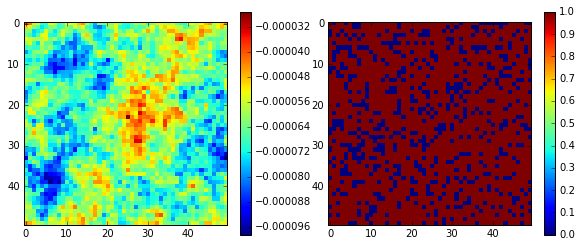

In [4]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [11]:
lmin,lmax = 200,5000
nbins = 8

lbins,pspec,bin_counts = img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False)
lbins,pspec_m,bin_counts = img2PS(img*mask,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False)

lbins_opt,q,Fdiag,Cinv = img2optimalPS(img*mask,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False,useCinv=False)
lbins_opt,q,Fdiag_useCinv,Cinv = img2optimalPS(img*mask,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False,useCinv=True)

5091.16882454
5091.16882454
generating Ccomma for bin 0
calculating q for bin 0
generating Ccomma for bin 1
calculating q for bin 1
generating Ccomma for bin 2
calculating q for bin 2
generating Ccomma for bin 3
calculating q for bin 3
generating Ccomma for bin 4
calculating q for bin 4
generating Ccomma for bin 5
calculating q for bin 5
generating Ccomma for bin 6
calculating q for bin 6
generating Ccomma for bin 7
calculating q for bin 7
generating Ccomma for bin 0
calculating q for bin 0
generating Ccomma for bin 1
calculating q for bin 1
generating Ccomma for bin 2
calculating q for bin 2
generating Ccomma for bin 3
calculating q for bin 3
generating Ccomma for bin 4
calculating q for bin 4
generating Ccomma for bin 5
calculating q for bin 5
generating Ccomma for bin 6
calculating q for bin 6
generating Ccomma for bin 7
calculating q for bin 7


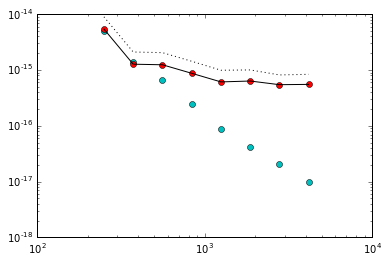

In [12]:
plt.loglog(lbins,pspec,'co')
plt.loglog(lbins,pspec_m,'ro') 

# plt.loglog(lbins_opt,np.real(inv(F)*q),'k-')
# plt.loglog(lbins_opt,np.real(inv(F_with_Cinv)*q),'k:',linewidth=4)

plt.loglog(lbins_opt,np.array(q).flatten()/Fdiag,'k-')
plt.loglog(lbins_opt,np.array(q).flatten()/Fdiag_useCinv,'k:')